In [2]:
import cv2
from skimage.feature import hog
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [8]:
IMAGE_SIZE = (64, 64)
VIEW_PORT = (960, 720)

# Function to extract HOG features from an image
def extract_features(image):
    hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2")
    return hog_features

# Function to perform sliding window detection
def sliding_window(image, window_size, stride):
    windows = []
    image_height, image_width = image.shape[:2]
    window_height, window_width = window_size
    for y in range(0, image_height - window_height + 1, stride):
        for x in range(0, image_width - window_width + 1, stride):
            window = image[y:y + window_height, x:x + window_width]
            windows.append(((x, y), (x + window_width, y + window_height), window))
    return windows

# Function to classify windows using the trained SVM model
def classify_windows(windows, model, scaler):
    classified_windows = []
    for (x1, y1), (x2, y2), window in windows:
        hog_features = extract_features(window).reshape(1, -1)
        scaled_features = scaler.transform(hog_features)
        prediction = model.predict(scaled_features)
        if prediction == 1:
            classified_windows.append(((x1, y1), (x2, y2), prediction))
    return classified_windows

# Function to read an image, grayscale it, and resize it 
def read_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, VIEW_PORT)
    return image

# Function to perform non-max suppression
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

In [9]:
time = "09-06-2024"

# Example usage on an image
image_path = 'dataset/fcv/IMG_2393.jpg'

image = read_image(image_path)

# Load the trained model and scaler
with open(f'svm_{time}.pkl', 'rb') as f:
    svm_classifier = pickle.load(f)

with open(f'scaler_{time}.pkl', 'rb') as f:
    scaler = pickle.load(f)

ROI shape: (360, 768)


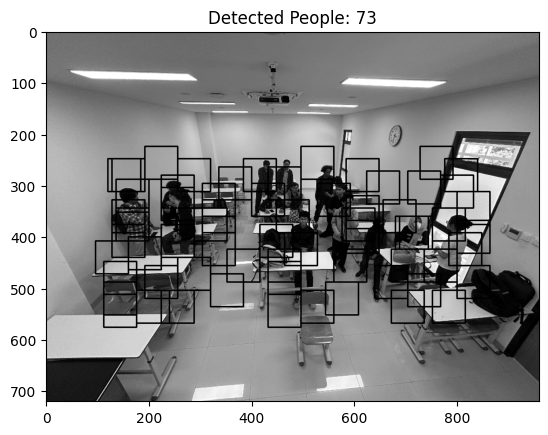

In [11]:
# Define ROI coordinates as a percentage of the image dimensions
xmin_pct = 0.1  # 10% from the left
ymin_pct = 0.3  # 20% from the top
xmax_pct = 0.9  # 90% to the right
ymax_pct = 0.8  # 80% to the bottom

# Calculate the actual ROI coordinates
height, width = image.shape
xmin = int(xmin_pct * width)
ymin = int(ymin_pct * height)
xmax = int(xmax_pct * width)
ymax = int(ymax_pct * height)

# windows = sliding_window(image, window_size=IMAGE_SIZE, stride=8)
# classified_windows = classify_windows(windows, svm_classifier, scaler)

# Crop the image using the ROI
roi = image[ymin:ymax, xmin:xmax]
print("ROI shape:", roi.shape)
windows = sliding_window(roi, window_size=IMAGE_SIZE, stride=8)
classified_windows = classify_windows(windows, svm_classifier, scaler)

boxes = np.array([(x1, y1, x2, y2) for (x1, y1), (x2, y2), _ in classified_windows])

# Apply non-max suppression
pick = non_max_suppression(boxes, 0.3)

# # Draw bounding boxes around classified windows
# for (x1, y1, x2, y2) in boxes:
#     cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Draw bounding boxes around classified windows
for (x1, y1, x2, y2) in pick:
    # Adjust the coordinates based on the ROI
    x1 += xmin
    y1 += ymin
    x2 += xmin
    y2 += ymin
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the roi with bounding boxes
plt.imshow(image, cmap='gray')

# Display the number of detected people
plt.title('Detected People: {}'.format(len(boxes)))
plt.show()